In [1]:
# Download the latest lightning version
!pip install pytorch-lightning
!pip install torch-lr-finder
!pip install albumentations
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.0/725.0 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 31.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110685 sha256=04060af631e5b968208ce4b50c48696e1d5e22ba17129b46ff6aaa7994b9d4a1
  Stored in directory: /root/.cache/pip/wheels/32/9a/1c/87cb7688472c9240fa865b94c59f8e63c8dd2a8cca1fd4dbb6
Successfully built kaggle


In [2]:
# Standard Library Imports
import os
import math
import sys
import warnings
warnings.filterwarnings("ignore")

# Third-Party Imports
import torch
import torch.optim as optim
from torch_lr_finder import LRFinder
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelSummary, LearningRateMonitor, ModelCheckpoint, LearningRateFinder
print(pl.__version__)

# Import files from the downloaded repository
!git clone https://github.com/Shilpaj1994/ERA.git
sys.path.insert(0,'./ERA/Session13/')

# Local Imports
import config
import utils
from yolo_model import YOLOv3
from loss import YoloLoss

2.0.7
fatal: destination path 'ERA' already exists and is not an empty directory.


In [3]:
# # Link the dataset
# !ln -s /datasets/pascal_voc PASCAL_VOC
# !ls

In [4]:
# # Download dataset from Kaggle
# !ls -al
# !pwd
# !cp ./kaggle.json /root/.kaggle
# !kaggle datasets download -d aladdinpersson/pascal-voc-dataset-used-in-yolov3-video

In [5]:
# !chmod 777 pascal-voc-dataset-used-in-yolov3-video.zip 
# !unzip pascal-voc-dataset-used-in-yolov3-video.zip

In [6]:
model = YOLOv3(num_classes=config.NUM_CLASSES)
model.data_directory = './'
model.set_training_config(epochs=40, batch_size=16)

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.52E-01


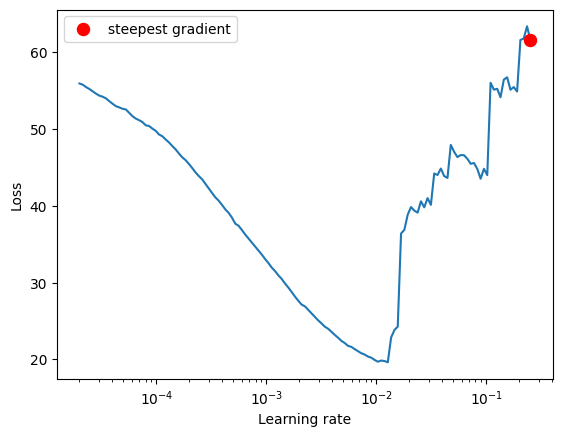

In [7]:
torch.cuda.empty_cache()

# LR finder
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
loss_fn = YoloLoss()

scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)


def criterion(out, y):
    y0, y1, y2 = (
        y[0].to(config.DEVICE),
        y[1].to(config.DEVICE),
        y[2].to(config.DEVICE),
    )
    loss = (
        loss_fn(out[0], y0, scaled_anchors[0]) +
        loss_fn(out[1], y1, scaled_anchors[1]) +
        loss_fn(out[2], y2, scaled_anchors[2])
    )
    return loss

lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(model.train_dataloader(), end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [8]:
model.learning_rate = 5.11E-04

In [9]:
# Monitor Learning rate while training to verify correct implementation of OCP
lr_monitor = LearningRateMonitor(logging_interval="epoch")

# Save the last best model based on validation loss
checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min',
)

# Define trainer for model training
trainer = pl.Trainer(
    callbacks=[ModelSummary(max_depth=-1), lr_monitor, checkpoint_callback],
    max_epochs = 40,
    precision='16-mixed',
    check_val_every_n_epoch=1,
    num_sanity_val_steps=1
)

# Train the Model
trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

    | Name                       | Type              | Params
-------------------------------------------------------------------
0   | layers                     | ModuleList        | 61.6 M
1   | layers.0                   | 

Sanity Checking: 0it [00:00, ?it/s]

Epoch: 0, Global Steps: 0, Val Loss: 47.49156951904297


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 1035: 'val_loss' reached 18.11279 (best 18.11279), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=0-step=1035.ckpt' as top 1


Epoch: 0, Global Steps: 1035, Val Loss: 18.11278533935547
Epoch: 0, Global Steps: 1035, Train Loss: 26.121990203857422


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 2070: 'val_loss' reached 15.76280 (best 15.76280), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=1-step=2070.ckpt' as top 1


Epoch: 1, Global Steps: 2070, Val Loss: 15.762800216674805
Epoch: 1, Global Steps: 2070, Train Loss: 14.2313814163208


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 3105: 'val_loss' reached 13.92267 (best 13.92267), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=2-step=3105.ckpt' as top 1


Epoch: 2, Global Steps: 3105, Val Loss: 13.922672271728516
Epoch: 2, Global Steps: 3105, Train Loss: 12.547112464904785


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 4140: 'val_loss' reached 12.03593 (best 12.03593), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=3-step=4140.ckpt' as top 1


Epoch: 3, Global Steps: 4140, Val Loss: 12.035926818847656
Epoch: 3, Global Steps: 4140, Train Loss: 11.411234855651855


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 5175: 'val_loss' was not in top 1


Epoch: 4, Global Steps: 5175, Val Loss: 12.1470308303833
Epoch: 4, Global Steps: 5175, Train Loss: 10.529383659362793


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 6210: 'val_loss' reached 11.03954 (best 11.03954), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=5-step=6210.ckpt' as top 1


Epoch: 5, Global Steps: 6210, Val Loss: 11.03954029083252
Epoch: 5, Global Steps: 6210, Train Loss: 9.846949577331543


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 7245: 'val_loss' reached 10.74510 (best 10.74510), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=6-step=7245.ckpt' as top 1


Epoch: 6, Global Steps: 7245, Val Loss: 10.745102882385254
Epoch: 6, Global Steps: 7245, Train Loss: 9.265609741210938


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 8280: 'val_loss' reached 10.53209 (best 10.53209), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=7-step=8280.ckpt' as top 1


Epoch: 7, Global Steps: 8280, Val Loss: 10.53209400177002
Epoch: 7, Global Steps: 8280, Train Loss: 8.892655372619629


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 9315: 'val_loss' was not in top 1


Epoch: 8, Global Steps: 9315, Val Loss: 10.578158378601074
Epoch: 8, Global Steps: 9315, Train Loss: 8.575005531311035


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 10350: 'val_loss' reached 10.13949 (best 10.13949), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=9-step=10350.ckpt' as top 1


Epoch: 9, Global Steps: 10350, Val Loss: 10.139490127563477
Epoch: 9, Global Steps: 10350, Train Loss: 8.301759719848633


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 11385: 'val_loss' reached 9.04480 (best 9.04480), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=10-step=11385.ckpt' as top 1


Epoch: 10, Global Steps: 11385, Val Loss: 9.044803619384766
Epoch: 10, Global Steps: 11385, Train Loss: 8.022172927856445


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 12420: 'val_loss' was not in top 1


Epoch: 11, Global Steps: 12420, Val Loss: 9.658945083618164
Epoch: 11, Global Steps: 12420, Train Loss: 7.7984418869018555


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 13455: 'val_loss' was not in top 1


Epoch: 12, Global Steps: 13455, Val Loss: 9.23003101348877
Epoch: 12, Global Steps: 13455, Train Loss: 7.583017826080322


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 14490: 'val_loss' reached 8.92472 (best 8.92472), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=13-step=14490.ckpt' as top 1


Epoch: 13, Global Steps: 14490, Val Loss: 8.92471981048584
Epoch: 13, Global Steps: 14490, Train Loss: 7.294214248657227


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 15525: 'val_loss' reached 8.59603 (best 8.59603), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=14-step=15525.ckpt' as top 1


Epoch: 14, Global Steps: 15525, Val Loss: 8.596033096313477
Epoch: 14, Global Steps: 15525, Train Loss: 7.040831565856934


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 16560: 'val_loss' reached 8.05561 (best 8.05561), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=15-step=16560.ckpt' as top 1


Epoch: 15, Global Steps: 16560, Val Loss: 8.055610656738281
Epoch: 15, Global Steps: 16560, Train Loss: 6.854904651641846


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 17595: 'val_loss' reached 7.95771 (best 7.95771), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=16-step=17595.ckpt' as top 1


Epoch: 16, Global Steps: 17595, Val Loss: 7.957713603973389
Epoch: 16, Global Steps: 17595, Train Loss: 6.688620567321777


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 18630: 'val_loss' reached 7.77754 (best 7.77754), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=17-step=18630.ckpt' as top 1


Epoch: 17, Global Steps: 18630, Val Loss: 7.777538299560547
Epoch: 17, Global Steps: 18630, Train Loss: 6.412613391876221


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 19665: 'val_loss' reached 7.21392 (best 7.21392), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=18-step=19665.ckpt' as top 1


Epoch: 18, Global Steps: 19665, Val Loss: 7.213915824890137
Epoch: 18, Global Steps: 19665, Train Loss: 6.228229999542236


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 20700: 'val_loss' was not in top 1


Epoch: 19, Global Steps: 20700, Val Loss: 7.514265060424805
Epoch: 19, Global Steps: 20700, Train Loss: 6.052502155303955


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 21735: 'val_loss' reached 6.98461 (best 6.98461), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=20-step=21735.ckpt' as top 1


Epoch: 20, Global Steps: 21735, Val Loss: 6.98460578918457
Epoch: 20, Global Steps: 21735, Train Loss: 5.89744758605957


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 22770: 'val_loss' was not in top 1


Epoch: 21, Global Steps: 22770, Val Loss: 7.065941333770752
Epoch: 21, Global Steps: 22770, Train Loss: 5.768936634063721


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 23805: 'val_loss' was not in top 1


Epoch: 22, Global Steps: 23805, Val Loss: 7.589943885803223
Epoch: 22, Global Steps: 23805, Train Loss: 5.588249206542969


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 24840: 'val_loss' was not in top 1


Epoch: 23, Global Steps: 24840, Val Loss: 7.334129810333252
Epoch: 23, Global Steps: 24840, Train Loss: 5.477383613586426


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 25875: 'val_loss' reached 6.40508 (best 6.40508), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=24-step=25875.ckpt' as top 1


Epoch: 24, Global Steps: 25875, Val Loss: 6.4050798416137695
Epoch: 24, Global Steps: 25875, Train Loss: 5.327764511108398


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 26910: 'val_loss' reached 5.97282 (best 5.97282), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=25-step=26910.ckpt' as top 1


Epoch: 25, Global Steps: 26910, Val Loss: 5.9728217124938965
Epoch: 25, Global Steps: 26910, Train Loss: 5.1883368492126465


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 27945: 'val_loss' was not in top 1


Epoch: 26, Global Steps: 27945, Val Loss: 6.097152233123779
Epoch: 26, Global Steps: 27945, Train Loss: 5.0380539894104


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 28980: 'val_loss' reached 5.96161 (best 5.96161), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=27-step=28980.ckpt' as top 1


Epoch: 27, Global Steps: 28980, Val Loss: 5.961605072021484
Epoch: 27, Global Steps: 28980, Train Loss: 4.8804097175598145


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 30015: 'val_loss' reached 5.94378 (best 5.94378), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=28-step=30015.ckpt' as top 1


Epoch: 28, Global Steps: 30015, Val Loss: 5.943782806396484
Epoch: 28, Global Steps: 30015, Train Loss: 4.807102203369141


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 31050: 'val_loss' reached 5.50448 (best 5.50448), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=29-step=31050.ckpt' as top 1


Epoch: 29, Global Steps: 31050, Val Loss: 5.504480361938477
Epoch: 29, Global Steps: 31050, Train Loss: 4.652400016784668


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 32085: 'val_loss' was not in top 1


Epoch: 30, Global Steps: 32085, Val Loss: 6.230386257171631
Epoch: 30, Global Steps: 32085, Train Loss: 4.56951904296875


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 33120: 'val_loss' was not in top 1


Epoch: 31, Global Steps: 33120, Val Loss: 5.577237129211426
Epoch: 31, Global Steps: 33120, Train Loss: 4.414254188537598


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 34155: 'val_loss' reached 5.08695 (best 5.08695), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=32-step=34155.ckpt' as top 1


Epoch: 32, Global Steps: 34155, Val Loss: 5.0869526863098145
Epoch: 32, Global Steps: 34155, Train Loss: 4.272596836090088


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 35190: 'val_loss' reached 4.90916 (best 4.90916), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=33-step=35190.ckpt' as top 1


Epoch: 33, Global Steps: 35190, Val Loss: 4.9091620445251465
Epoch: 33, Global Steps: 35190, Train Loss: 4.155636310577393


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 36225: 'val_loss' was not in top 1


Epoch: 34, Global Steps: 36225, Val Loss: 4.93949556350708
Epoch: 34, Global Steps: 36225, Train Loss: 4.06797981262207


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 37260: 'val_loss' reached 4.69088 (best 4.69088), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=35-step=37260.ckpt' as top 1


Epoch: 35, Global Steps: 37260, Val Loss: 4.690880298614502
Epoch: 35, Global Steps: 37260, Train Loss: 3.954512596130371


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 38295: 'val_loss' was not in top 1


Epoch: 36, Global Steps: 38295, Val Loss: 4.870270729064941
Epoch: 36, Global Steps: 38295, Train Loss: 3.8322622776031494


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 39330: 'val_loss' was not in top 1


Epoch: 37, Global Steps: 39330, Val Loss: 4.869865417480469
Epoch: 37, Global Steps: 39330, Train Loss: 3.72934889793396


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 40365: 'val_loss' was not in top 1


Epoch: 38, Global Steps: 40365, Val Loss: 4.847742080688477
Epoch: 38, Global Steps: 40365, Train Loss: 3.633148431777954


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 41400: 'val_loss' reached 4.52388 (best 4.52388), saving model to '/notebooks/lightning_logs/version_2/checkpoints/epoch=39-step=41400.ckpt' as top 1


Epoch: 39, Global Steps: 41400, Val Loss: 4.52388334274292
Epoch: 39, Global Steps: 41400, Train Loss: 3.5980098247528076


`Trainer.fit` stopped: `max_epochs=40` reached.


In [10]:
torch.save(model.state_dict(), 'yolo_v3.pth')

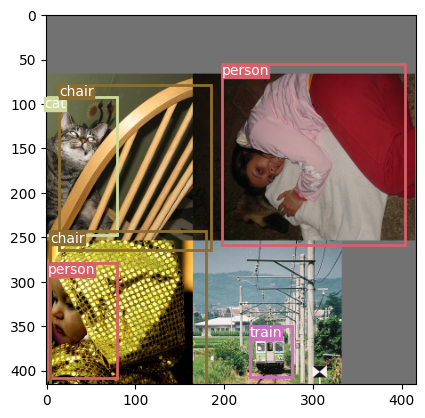

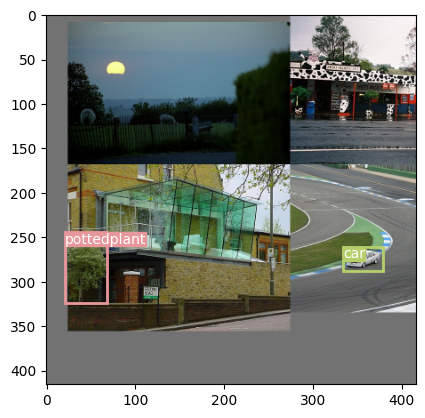

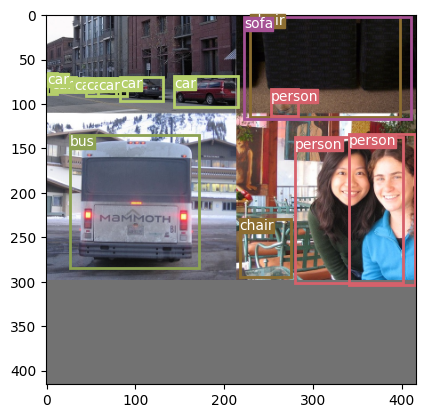

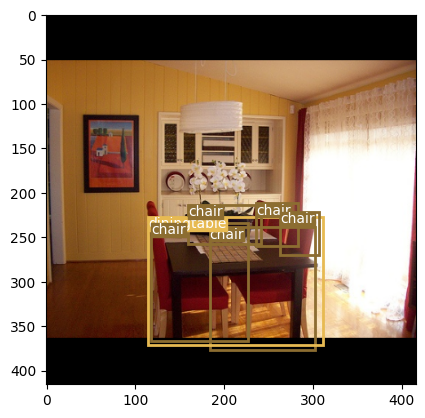

In [11]:
utils.plot_couple_examples(model.to('cuda'), model.test_dataloader(), 0.6, 0.5, scaled_anchors.to('cuda'))